In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import time

### `generate_dataset`

#### Parameters:
- `n_samples`: Number of data points.
- `n_true_predictors`: Number of effective features.
- `n_non_effective_predictors`: Number of noise features.

#### Steps:

1. **Generate Predictors**:  
   **True Predictors**: `n_true_predictors` arrays of random values.  
   **Non-effective Predictors**: `n_non_effective_predictors` arrays of random values.

2. **Define Coefficients and Intercept**:  
   `beta_0`: Intercept (3.0).  
   `true_coefficients`: Random values (3.5 to 8) for true predictors.

3. **Generate Error Term**:  
   Random noise from a standard normal distribution.

4. **Generate Outcome Variable (`y`)**:  
   Calculated as the sum of the intercept, true predictors multiplied by their coefficients, and the error term.

5. **Combine Predictors into a DataFrame**:  
   Creates a DataFrame with predictors and the outcome variable `y`.

6. **Return**:  
   The DataFrame and true coefficients.

In [29]:
def generate_dataset(n_samples, n_true_predictors, n_non_effective_predictors):
    np.random.seed(8)
    
    # Generate true predictors
    true_predictors = [np.random.rand(n_samples, 1) for _ in range(n_true_predictors)]
    
    # Generate non-effective predictors
    non_effective_predictors = [np.random.rand(n_samples, 1) for _ in range(n_non_effective_predictors)]
    
    # Define the true coefficients and intercept
    beta_0 = 3.0
    true_coefficients = np.random.uniform(2, 10, size=n_true_predictors)
    
    # Generate the error term
    error = np.random.randn(n_samples, 1)
    
    # Generate the outcome variable
    y = beta_0 + sum(beta * x for beta, x in zip(true_coefficients, true_predictors)) + error
    
    # Combine all predictors into a single DataFrame
    predictors = np.hstack(true_predictors + non_effective_predictors)
    columns = [f'x{i+1}' for i in range(n_true_predictors + n_non_effective_predictors)]
    data = pd.DataFrame(predictors, columns=columns)
    data['y'] = y
    
    return data, true_coefficients

In [30]:
# Generate the dataset
n_samples = 10_000
n_true_predictors = 10
n_non_effective_predictors = 50
data, true_coefficients = generate_dataset(n_samples, n_true_predictors, n_non_effective_predictors)

true_coefficients

array([2.22025318, 8.44593965, 7.52028276, 5.99870628, 9.84972407,
       4.48982787, 9.86080807, 2.72998414, 5.97873507, 4.71726804])

In [31]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,y
0,0.873429,0.523609,0.475082,0.968232,0.372132,0.572423,0.849903,0.130545,0.254798,0.103293,...,0.824939,0.246947,0.697428,0.519007,0.608745,0.587543,0.445331,0.823193,0.801308,34.502851
1,0.968541,0.943392,0.771450,0.676999,0.077522,0.452592,0.843904,0.199732,0.066323,0.922206,...,0.451648,0.878806,0.222854,0.981116,0.166460,0.781131,0.892337,0.658607,0.298787,39.328077
2,0.869195,0.436470,0.812549,0.822084,0.189379,0.689384,0.565280,0.068552,0.325774,0.599747,...,0.459671,0.488060,0.398422,0.029529,0.943491,0.704469,0.337591,0.555235,0.056626,34.280415
3,0.530856,0.762821,0.393791,0.518521,0.946634,0.593414,0.559811,0.179643,0.868602,0.222248,...,0.289230,0.530392,0.381445,0.017569,0.636128,0.355842,0.322769,0.501918,0.708577,41.607036
4,0.232728,0.935329,0.073132,0.127392,0.114611,0.886882,0.961259,0.162081,0.828392,0.772161,...,0.902066,0.649915,0.363424,0.728759,0.822401,0.799640,0.379559,0.494045,0.020301,38.700760


In [32]:
data.shape

(10000, 61)

In [33]:
X = data.drop(columns='y')
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

## Basic linear model for baseline coeff in order to compare how Lasso changes the coeff

In [34]:
basic_lr = LinearRegression()

# Fit the model to the training data
basic_lr.fit(X_train, y_train)

lr_pred = basic_lr.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, lr_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1.0162393055841201


In [35]:
initial_coefficients = basic_lr.coef_
initial_coefficients

array([ 2.22879193e+00,  8.47430856e+00,  7.55132844e+00,  6.02976145e+00,
        9.81779803e+00,  4.50398015e+00,  9.83475023e+00,  2.76768360e+00,
        5.90137683e+00,  4.73875458e+00, -3.03759197e-02,  2.80487832e-03,
       -7.04899847e-02,  1.73539957e-02, -2.79427075e-02, -4.17794458e-02,
       -6.01114290e-03,  1.08002471e-02, -2.87589685e-02,  1.62158432e-02,
        3.36042111e-02,  2.13170334e-03,  1.80619761e-02,  2.96008342e-02,
       -4.74633105e-02,  4.50863163e-02,  3.69638070e-02, -3.51626762e-02,
        7.75822206e-02,  5.25528950e-02,  7.44222570e-02, -6.64910987e-02,
       -8.01950352e-03,  1.52999821e-03,  1.62447713e-02,  8.49445990e-03,
       -2.72989606e-02, -3.14753568e-02,  2.33667689e-02,  2.35172896e-02,
        7.74878329e-02,  3.64628047e-02, -7.95010591e-02,  8.10395516e-03,
       -2.58625445e-02, -3.35593129e-02,  3.30408032e-02,  2.30946566e-02,
        1.01116825e-01,  2.23150250e-02,  2.07805957e-02, -5.56362623e-02,
        7.98266499e-03,  

In [36]:
# Define the Lasso model
lasso = LassoCV(cv=5, random_state=8, n_jobs=-1)  

start_time = time.time()
lasso.fit(X_train, y_train)

best_alpha = lasso.alpha_
print("Optimal alpha:", best_alpha)

Optimal alpha: 0.0034295740214712184


In [37]:
lasso_final = Lasso(alpha=best_alpha)

# Fit the final model to the training data
lasso_final.fit(X_train, y_train)

# Predict on test data and time
y_pred = lasso_final.predict(X_test)
end_time = time.time()

In [38]:
# Calculate the mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 1.0084749223082106


In [39]:
r2 = r2_score(y_test, y_pred)
print(f"R^2 score: {r2}")

R^2 score: 0.973096545533902


In [40]:
estimation_time = end_time - start_time
print(estimation_time)

0.1882469654083252


In [41]:
lasso_coefficients = lasso_final.coef_
lasso_coefficients

array([ 2.18615220e+00,  8.43097217e+00,  7.50520266e+00,  5.99009350e+00,
        9.78002270e+00,  4.46108691e+00,  9.79199808e+00,  2.72430599e+00,
        5.86140002e+00,  4.69558279e+00, -0.00000000e+00,  0.00000000e+00,
       -2.56963495e-02,  0.00000000e+00, -0.00000000e+00, -4.71504059e-05,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -5.53096905e-03,  3.52556851e-03,  0.00000000e+00, -0.00000000e+00,
        3.65462016e-02,  2.14008474e-02,  3.15368374e-02, -2.03104366e-02,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.65863475e-02,  0.00000000e+00, -3.52901366e-02,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.84207916e-02,  0.00000000e+00,  0.00000000e+00, -1.23341743e-02,
        0.00000000e+00,  

In [42]:
start_time = time.time()

# Create a DataFrame to compare the coefficients
coefficients_df = pd.DataFrame({
    'Feature_Index': np.arange(len(X.columns)),
    'Feature': X.columns,
    'Initial_Coefficients': initial_coefficients,
    'Lasso_Coefficients': lasso_coefficients
})

zero_indices = coefficients_df[coefficients_df['Lasso_Coefficients'] == 0]['Feature_Index']

In [43]:
coefficients_df

,Feature_Index,Feature,Initial_Coefficients,Lasso_Coefficients
0,0,x1,2.228792,2.186152
1,1,x2,8.474309,8.430972
2,2,x3,7.551328,7.505203
3,3,x4,6.029761,5.990094
4,4,x5,9.817798,9.780023
5,5,x6,4.503980,4.461087
6,6,x7,9.834750,9.791998
7,7,x8,2.767684,2.724306
8,8,x9,5.901377,5.861400
9,9,x10,4.738755,4.695583


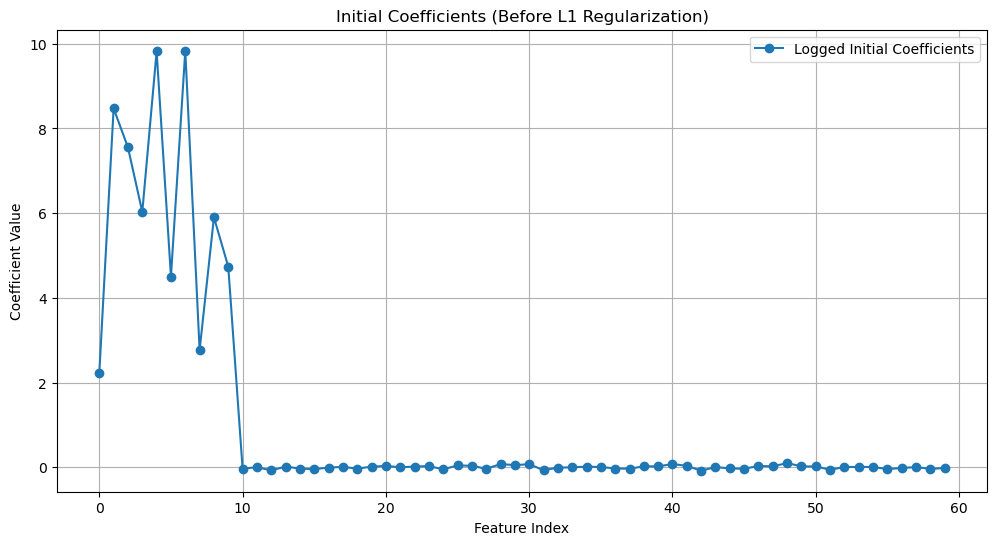

In [44]:
# Plot initial coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_df['Feature_Index'], coefficients_df['Initial_Coefficients'], marker='o', label='Logged Initial Coefficients', linestyle='-')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Initial Coefficients (Before L1 Regularization)')
plt.legend()
plt.grid(True)
plt.show()


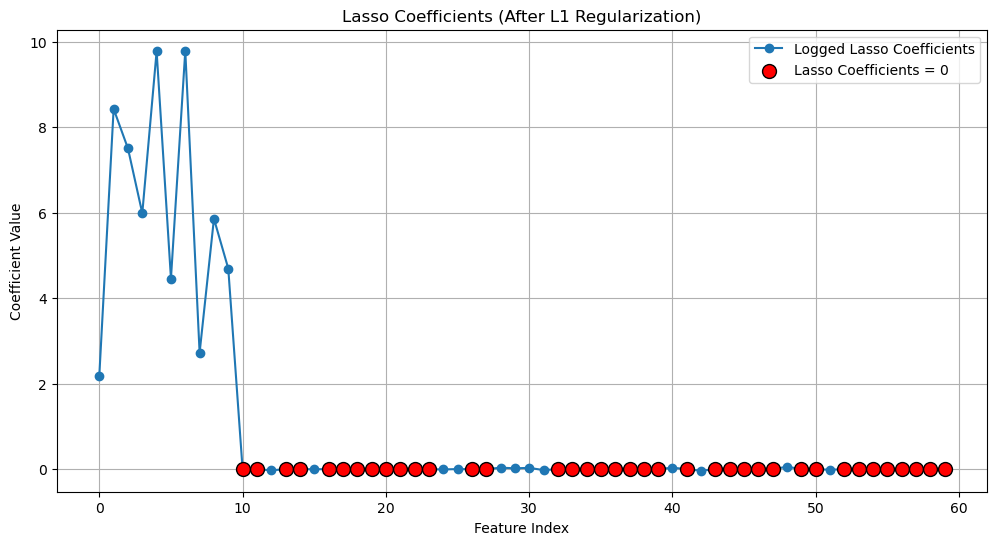

In [45]:
# Plot Lasso coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_df['Feature_Index'], coefficients_df['Lasso_Coefficients'], marker='o', label='Logged Lasso Coefficients', linestyle='-')
plt.scatter(zero_indices, np.zeros(len(zero_indices)), color='red', edgecolor='black', s=100, zorder=5, label='Lasso Coefficients = 0')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients (After L1 Regularization)')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
coefficients_df = coefficients_df.sort_values(by="Lasso_Coefficients", ascending=False).reset_index(drop=True)
coefficients_df

,Feature_Index,Feature,Initial_Coefficients,Lasso_Coefficients
0,6,x7,9.834750,9.791998
1,4,x5,9.817798,9.780023
2,1,x2,8.474309,8.430972
3,2,x3,7.551328,7.505203
4,3,x4,6.029761,5.990094
5,8,x9,5.901377,5.861400
6,9,x10,4.738755,4.695583
7,5,x6,4.503980,4.461087
8,7,x8,2.767684,2.724306
9,0,x1,2.228792,2.186152


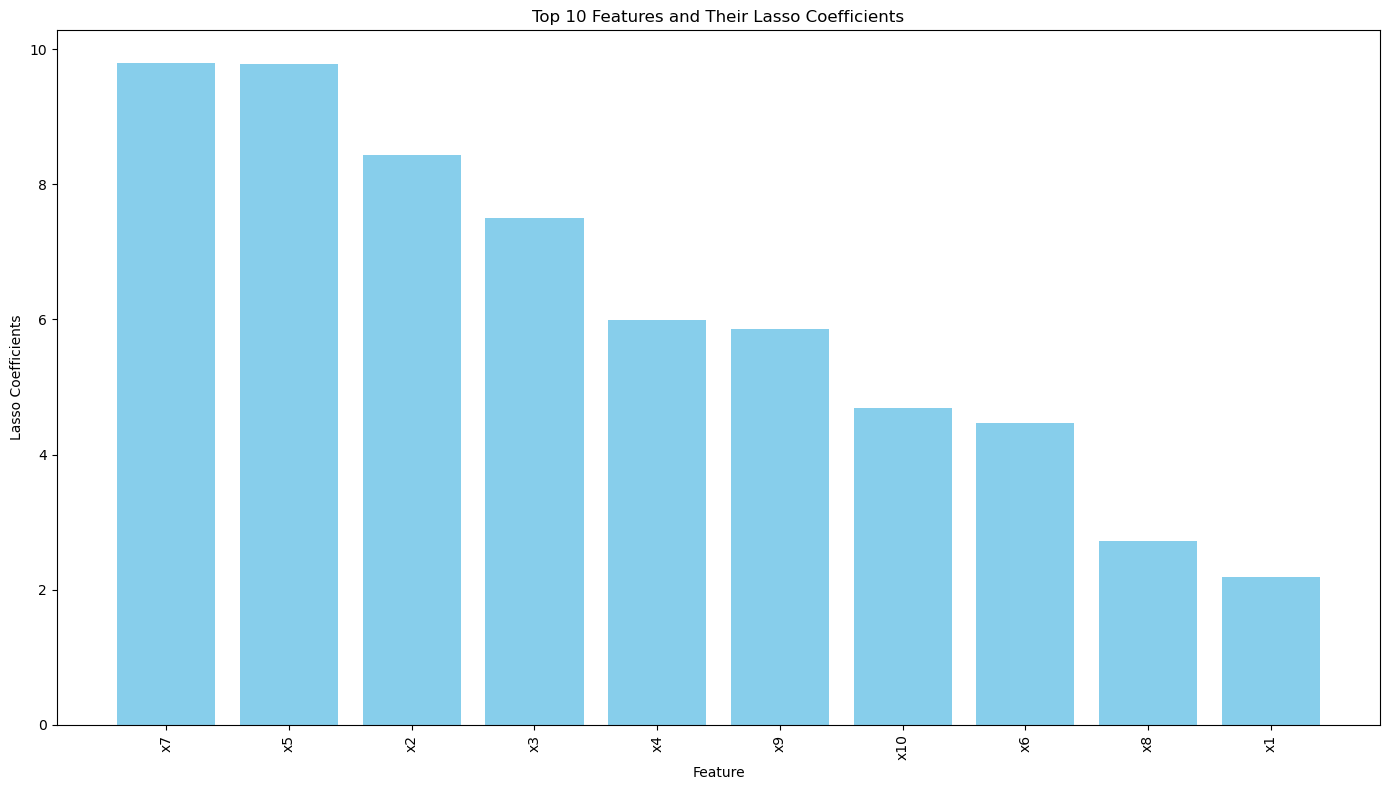

In [47]:
top_10_features = coefficients_df[['Feature', 'Lasso_Coefficients']]
top_10_filtered_df = top_10_features.head(10)

plt.figure(figsize=(14, 8))

plt.bar(top_10_filtered_df['Feature'], top_10_filtered_df['Lasso_Coefficients'], color='skyblue')

plt.xlabel('Feature')
plt.ylabel('Lasso Coefficients')
plt.title('Top 10 Features and Their Lasso Coefficients')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

end_time = time.time()

In [48]:
explainability_time = end_time - start_time

In [49]:
# Create a DataFrame for the results
results = pd.DataFrame({'True Values': y_test, 'Predicted Values': y_pred}).reset_index(drop=True)
results

,True Values,Predicted Values
0,29.378133,29.720708
1,35.069608,35.377050
2,32.373896,33.352041
3,36.646602,39.620483
4,34.401457,31.380758
...,...,...
1995,33.930935,34.931766
1996,28.957571,29.905927
1997,22.492000,22.499651
1998,30.915866,31.201988


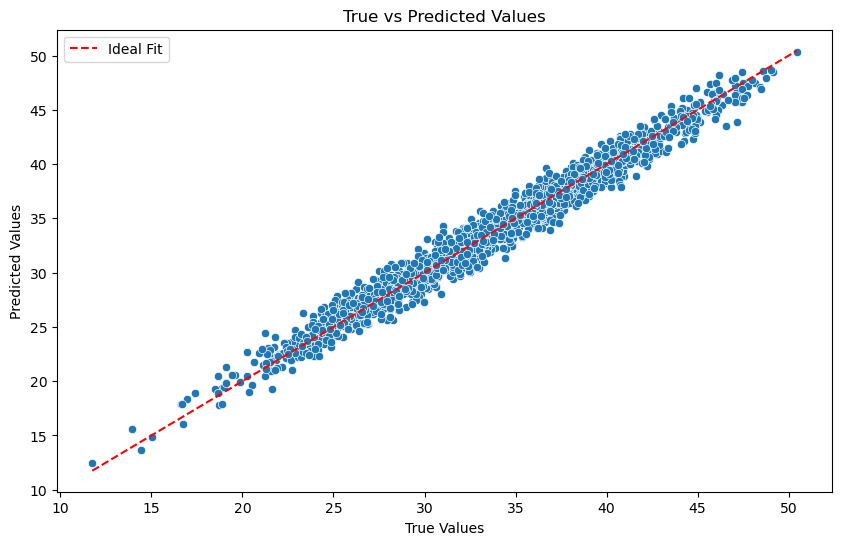

In [50]:
# Plot the true vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x='True Values', y='Predicted Values', data=results)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

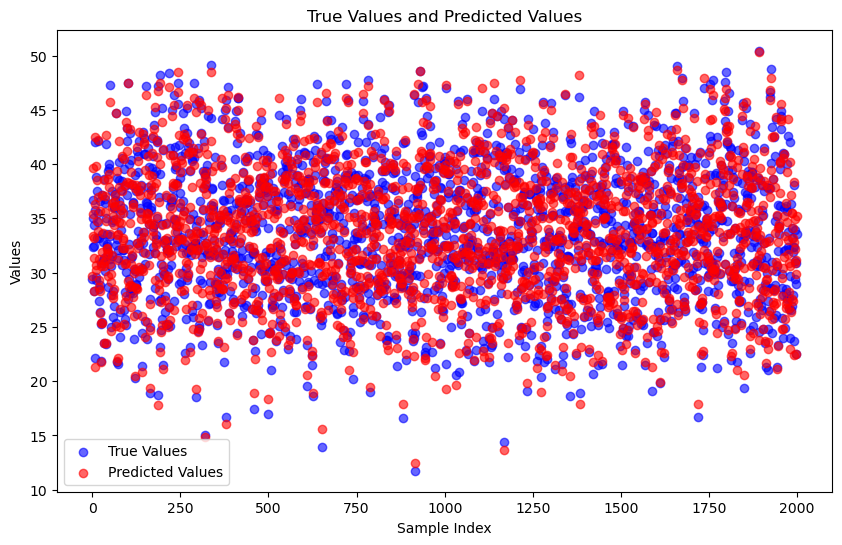

In [51]:
# Plot the true vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', alpha=0.6, label='True Values')
plt.scatter(range(len(y_pred)), y_pred, color='red', alpha=0.6, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.title('True Values and Predicted Values')
plt.legend()
plt.show()

In [52]:
# # Exclude non-numeric columns
# corrmat = data.corr()

# f, ax = plt.subplots(figsize=(15, 12))
# sns.heatmap(corrmat, annot=True);

In [53]:
# # Threshold for identifying multicollinearity
# threshold = 0.5

# # Find pairs of highly correlated features
# high_corr_var = {}
# for i in range(len(corrmat.columns)):
#     for j in range(i):
#         if abs(corrmat.iloc[i, j]) > threshold:
#             colname = corrmat.columns[i]
#             if colname not in high_corr_var:
#                 high_corr_var[colname] = corrmat.columns[j]

# print("Highly correlated features (above threshold of {}):".format(threshold))
# for key, value in high_corr_var.items():
#     print(key, "<--->", value)

## shows no multicollinearity in random generated data

# Time to collect result metrics

In [54]:
lasso_metrics = []
# LassoCV model metrics
#fpr, fnr = calculate_fp_fn_rates(cf_matrix)
lasso_metrics.append({
    'Simulation Size': '10-50-10_000',
    'Model': 'Lasso',
    'Inference Time (sec)': round(estimation_time, 3),
    'R Squared': r2,
    'RMSE': rmse,
    'Explanation/Interpretation Task': 'Interpret LASSO',
    'Interpretation Time (sec)': round(explainability_time, 3),
    #'top_10_features': top_10_features_str
    # 'auc': round(roc_auc, 3),
    # 'false_positive_rate': round(fpr, 3),
    # 'false_negative_rate': round(fnr, 3)
})

lasso_metrics_df = pd.DataFrame(lasso_metrics)
lasso_metrics_df

,Simulation Size,Model,Inference Time (sec),R Squared,RMSE,Explanation/Interpretation Task,Interpretation Time (sec)
0,10-50-10_000,Lasso,0.188,0.973097,1.008475,Interpret LASSO,0.931


In [55]:
lasso_metrics_df.to_csv('10-50-10_000-metrics.csv', index=False)